# Transfer Learning from PatchCore to MLP
The following document will attempt a solutiont to abstract PatchCore away in order to hide the memory bank.  
By hiding the memory bank, we become able to use HomoMorphic Encryption on the model.

**This document follows these steps:**
1. Train PatchCore on half the dataset **dataset_a** -> result: patchCore model (**ModelA**)
2. Evaluate the resulting model (we care about AUROC)
3. Use **modelA** to add labels (*anomaly scores*)to all patches within the images in **dataset_b** -> **annotated_dataset_b**.
4. Use annotated_dataset_b to train a MLP model **ModelB**
5. With ModelB, estimate patch scores for test data patches.
6. Test the model effictiveness of ModelB.
7. Conclusion on the performance of ModelB

## (1) Training PatchCore

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pytorch_lightning import Trainer, seed_everything

from config import get_configurable_parameters
from data import get_datamodule
from models import get_model
from utils.callbacks import LoadModelCallback, get_callbacks

# config
config = get_configurable_parameters(model_name="patchcore", config_path="config.yaml")
if config.project.get("seed") is not None:
    seed_everything(config.project.seed)

# prepare dataomdule
datamodule = get_datamodule(config)

# prepare model
model = get_model(config)
callbacks = get_callbacks(config)

# fit the model
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)  # pylint: disable=no-member

Global seed set to 0
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | PatchcoreModel           | 24.9 M
3 | image_metrics         | AnomalibMetric

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## (2) Evaluate the resulting model model_a

In [3]:
trainer.test(model=model, datamodule=datamodule)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9715957045555115
       pixel_AUROC          0.9759382605552673
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'pixel_AUROC': 0.9759382605552673, 'image_AUROC': 0.9715957045555115}]

## (3) Preprocessing: Annotate dataset_b

In [4]:
import json
import torch
from typing import List

from inferencer import TorchInferencer
from data.utils import get_image_filenames, read_image


inferencer = TorchInferencer(
    config=config,
    model_source="output/results/patchcore/mvtec/grid/run/weights/lightning/model.ckpt",
    device="auto"
)
model = inferencer.model.model
filenames = get_image_filenames(path="datasets/MVTec_b/grid/")

def generate_embeddings(filenames: List[str]):  #  -> Tuple(List[patches], List[patchScores])
    embeddings = []
    outputs = []
    print("Preparing data for training by generating embeddings")
    for i, filename in enumerate(filenames):
        image_arr = read_image(filename)
        metadata = inferencer.metadata
        metadata["image_shape"] = image_arr.shape[:2]
        processed_image = inferencer.pre_process(image_arr)
    
        # generating embeddings
        with torch.no_grad():
            features = model.feature_extractor(processed_image)
        features = {layer: model.feature_pooler(feature) for layer, feature in features.items()}
        embedding = model.generate_embedding(features)
        batch_size, _, width, height = embedding.shape
        embedding = model.reshape_embedding(embedding)

        embeddings += embedding.tolist()

        # calculating anomaly score / patch
        outputs += model.nearest_neighbors(embedding=embedding, n_neighbors=1)[0].tolist()

        if (i + 1) % 25 == 0:
            print(f"Finished {i + 1} out of {len(filenames)} images")

    print("Finished all!")
    return embeddings, outputs

## (4) Train the MLP model

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [47]:
# preparing training dataset
# we use dataset_b + a percentage of the test dataset.

test_images_used_for_training, test_images_used_for_test = train_test_split(
    get_image_filenames("datasets/MVTec_b/grid/test"),
    test_size=0.35, random_state=4
)
training_images =  get_image_filenames("datasets/MVTec_b/grid/train") + test_images_used_for_training
train_data, train_data_output = generate_embeddings(training_images)

# preparing test dataset
test_data, test_data_output = generate_embeddings(test_images_used_for_test)

Preparing data for training by generating embeddings
Finished 25 out of 181 images
Finished 50 out of 181 images
Finished 75 out of 181 images
Finished 100 out of 181 images
Finished 125 out of 181 images
Finished 150 out of 181 images
Finished 175 out of 181 images
Finished all!
Preparing data for training by generating embeddings
Finished 25 out of 28 images
Finished all!


In [48]:
import time

s = time.time()

# training the model
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', random_state=42)
mlp.fit(train_data, train_data_output)

print(f"Took {int((time.time() - s) / 60)} minutes")

Took 14 minutes


## (5) Evaluating the MLP model on input data

In [49]:
# Simple evaluation of the model
import numpy as np
from sklearn.metrics import mean_squared_error

# RMSE for training data 
pred_output = mlp.predict(train_data)
mse = mean_squared_error(train_data_output, pred_output)
rmse = np.sqrt(mse)
print(f"Train RMSE: {rmse}")
r2_score = mlp.score(train_data, train_data_output)
print(f"Train R^2 score: {r2_score:.2f}")

# RMSE for test data 
pred_output = mlp.predict(test_data)
mse = mean_squared_error(test_data_output, pred_output)
rmse = np.sqrt(mse)
print(f"------ \n Test RMSE: {rmse}")
r2_score = mlp.score(test_data, test_data_output)
print(f"Test R^2 score: {r2_score:.2f}")

Train RMSE: 0.886493322270335
Train R^2 score: 0.95
------ 
 Test RMSE: 2.7406874816168756
Test R^2 score: 0.66


### Alternative models
I have tested different configuration of the MLP model. Here's a summary of them and their evaluation

| Architecture | Activation | $R^2$ training/test | RMSE training/test | test_data_percentage|
|--------------|------------|---------------------|--------------------|---------------------|
| 100x50       |    relu    |     0.95/0.73       |      0.862/2.45    |     50%             |
| 500x100      |    relu    |     0.97/0.71       |      0.647/2.51    |     40%             |
| 100x50       |    relu    |     0.96/0.74       |      0.823/2.39    |     40%             |
| 100x50       |    relu    |     0.96/0.69       |      0.808/2.6     |     35%             |

## (6) Testing PatchCore anomaly scoring performance against our new MLP model

### Steps 
1. Prepare the dataset to be used. This is a list of embeddings for all images in the dataset
2. Run PatchCore on the given dataset and store the resulting patch score values in an array
3. Run the same dataset on the MLP model, and store the results
4. Plot both numbers against each other

Question: What exactly should we plot?
We need a good metric to measure the deviation of the MLP results from the patchCore results.

In [50]:
## step1 - prepare the test dataset
import torch

from data.utils import get_image_filenames, read_image
from inferencer import TorchInferencer
from post_processing import Visualizer


inferencer = TorchInferencer(
    config="config.yaml",
    model_source="output/results/patchcore/mvtec/grid/run/weights/lightning/model.ckpt",
)
patchcore_model = inferencer.model.model

metadata = getattr(inferencer, "metadata")

embeddings = []
for filename in test_images_used_for_test:
    image_arr=read_image(filename)
    metadata["image_shape"] = image_arr.shape[:2]

    processed_image = inferencer.pre_process(image_arr)

    with torch.no_grad():
        features = patchcore_model.feature_extractor(processed_image)  # 2nd and 3rd layer
    
    features = {layer: patchcore_model.feature_pooler(feature) for layer, feature in features.items()}
    embedding = patchcore_model.generate_embedding(features)

    batch_size, _, width, height = embedding.shape
    embedding = patchcore_model.reshape_embedding(embedding)
    embeddings.append(embedding)

len(embeddings)

28

In [51]:
## step 2 - patch score results
### patchcore results for the given 78 images flattened
patchcore_results = []
for embedding in embeddings:
    patch_scores_patchcore, _ = patchcore_model.nearest_neighbors(embedding=embedding, n_neighbors=1)
    patchcore_results += patch_scores_patchcore

In [52]:
## step 3 - MLP results
### MLP model results for the given 78 images
mlp_results = []
for embedding in embeddings:
    patch_scores_mlp_model = mlp.predict(embedding).tolist()
    mlp_results += patch_scores_mlp_model

In [53]:
import matplotlib.pyplot as plt


def draw_two_plots(y1, y2, x_axis="Patch Index", y_axis="Anomaly Score", title="PatchCore vs MLP"):
    fig, ax = plt.subplots()
    
    ax.plot(y1, color='red', label="patchCore")
    ax.plot(y2, color='blue', label="MLP")
    
    # Add labels and title
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_title(title)
    ax.legend()
    plt.show()

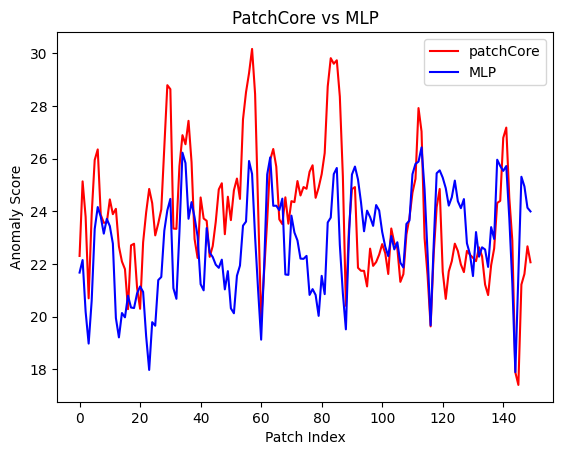

In [54]:
draw_two_plots(patchcore_results[11000:11150], mlp_results[11000:11150])


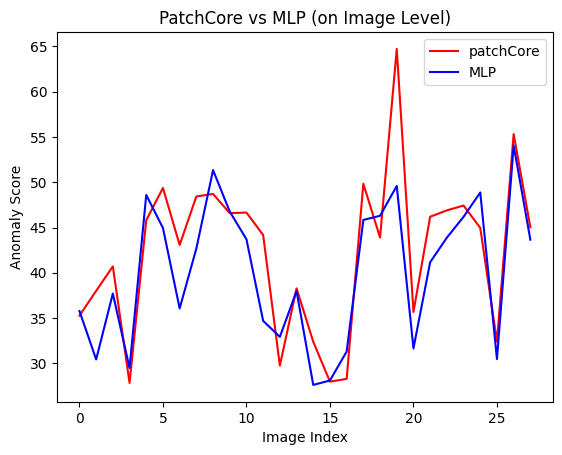

In [55]:
# Measuring the image-level anomaly scores deviation

patchcore_image_results = []
for embedding in embeddings:  # We use the Max function to determine the image patch score
    patch_scores_patchcore, _ = patchcore_model.nearest_neighbors(embedding=embedding, n_neighbors=1)
    patchcore_image_results.append(max(patch_scores_patchcore))
len(patchcore_image_results)

mlp_image_results = []
for embedding in embeddings:
    patch_scores_mlp_model = mlp.predict(embedding).tolist()
    mlp_image_results.append(max(patch_scores_mlp_model))
len(mlp_image_results)

draw_two_plots(patchcore_image_results, mlp_image_results, x_axis="Image Index", title='PatchCore vs MLP (on Image Level)')

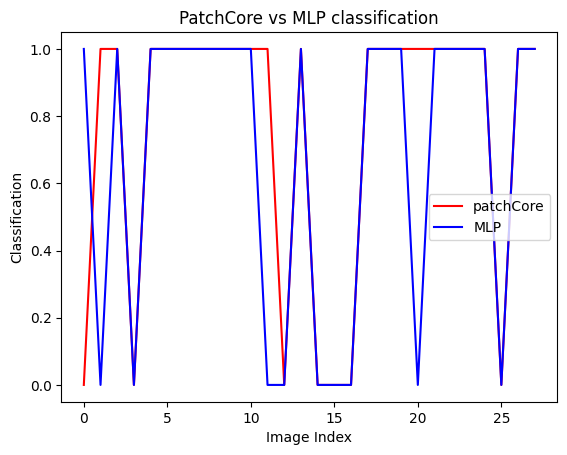

In [56]:
# Measuring the image-level classification deviation
threshold = inferencer.metadata["image_threshold"]

# 1 means anomalous - 0 means non-anomalous
patchcore_image_results_class = [1 if res > threshold else 0 for res in patchcore_image_results]
mlp_image_results_class        = [1 if res > threshold else 0 for res in mlp_image_results]
# truth_class = [0 if "good" in str(f) else 1 for f in test_images_used_for_test]

draw_two_plots(patchcore_image_results_class, mlp_image_results_class, x_axis="Image Index", y_axis="Classification", title='PatchCore vs MLP classification')

## Conclusion

The MLP model does a better job than the Linear regression model, but it's still not close enough to the patchCore results.

In a following experiment, we will add the anomalous data to the dataset_b to observe if that improves the model's ability to predict anomalous data.

## Appendix (additional graphs)

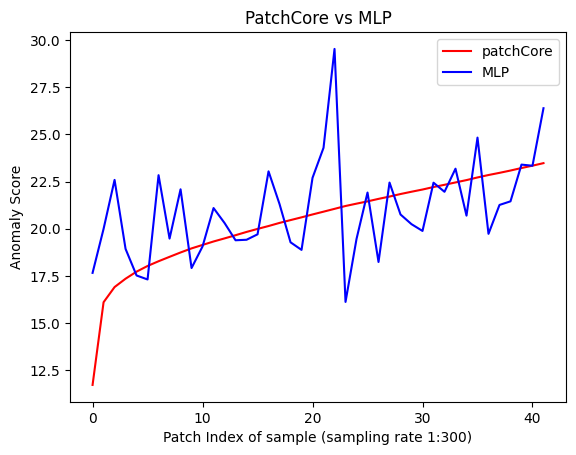

In [57]:
# Clearly show the deviation by ordering the patchCore results by lowest to highest

# this line creates a list of pairs of (patchcore result, MLP result) for each patch
y12 = zip(patchcore_results, mlp_results)

# we sort by patchcore result from lowest to highest - while keeping the second element to the MLP value
y12 = sorted(y12, key=lambda x: x[0])

# we split again patchcore (y1) from MLP (y2) so we can plot them
y1 = [x[0] for x in y12]
y2 = [x[1] for x in y12]
draw_two_plots(y1[:12500:300], y2[:12500:300], x_axis="Patch Index of sample (sampling rate 1:300)")

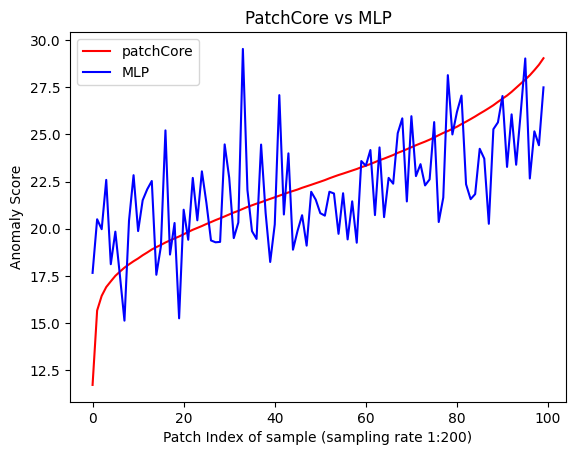

In [58]:
# Drawing 200 patch scores samples at 1/20 (we present 1 then skip 19, for 100 times)
draw_two_plots(y1[0:20000:200], y2[0:20000:200], x_axis="Patch Index of sample (sampling rate 1:200)")

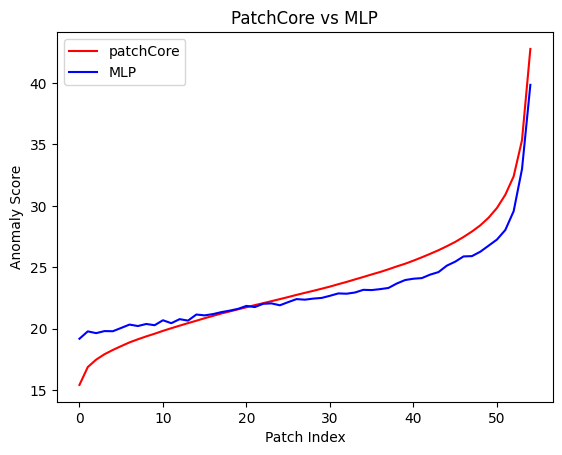

In [59]:
# sampling by taking the mean
import numpy as np

sample_width = 400
y1_sampled, y2_sampled = [], []
for lower_bound in range(1, len(y1), sample_width):
    upper_bound = lower_bound + sample_width
    upper_bound = len(y1) if upper_bound > len(y1) else upper_bound
    y1_sampled.append(np.mean(y1[lower_bound:upper_bound]))
    y2_sampled.append(np.mean(y2[lower_bound:upper_bound]))

draw_two_plots(y1_sampled, y2_sampled)

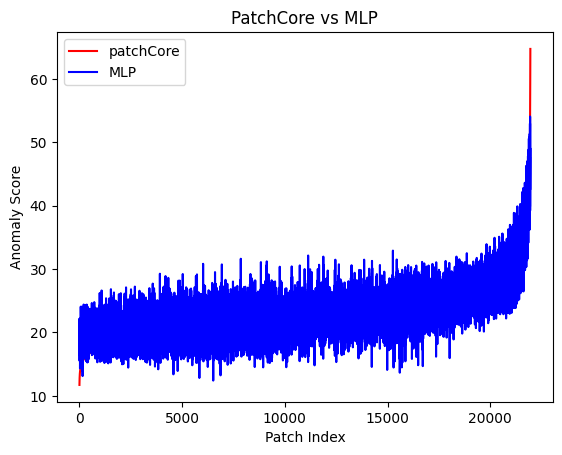

In [60]:
draw_two_plots(y1, y2)

### plotting image comparisons over ordered results

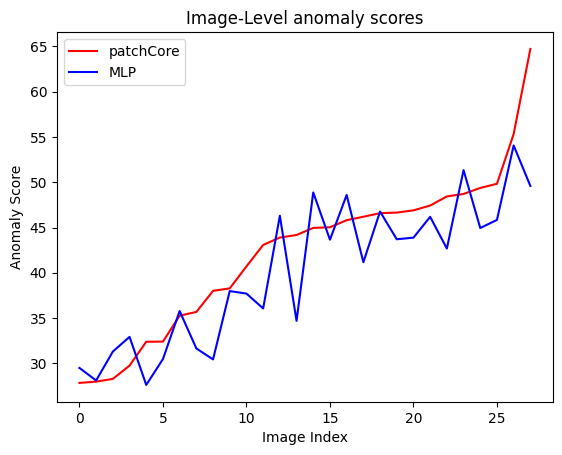

In [61]:
y12_images = zip(patchcore_image_results, mlp_image_results)

# we sort by patchcore result from lowest to highest - while keeping the second element to the MLP value
y12_images = sorted(y12_images, key=lambda x: x[0])

y1_images = [x[0] for x in y12_images]
y2_images = [x[1] for x in y12_images]
draw_two_plots(y1_images, y2_images, x_axis="Image Index", title="Image-Level anomaly scores")

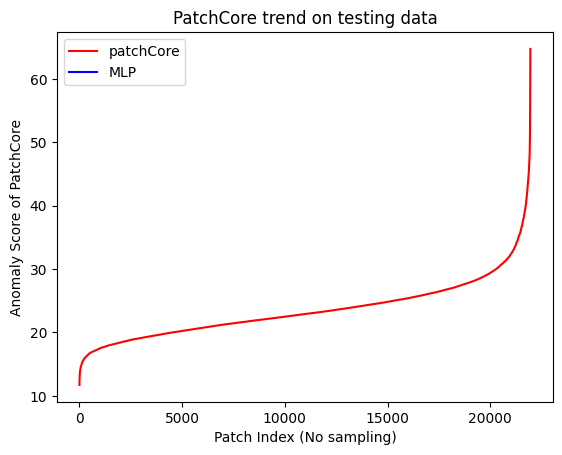

In [62]:
# This graph should give an insight on the distribution of anomaly scores on the test dataset. 

draw_two_plots(y1, [], x_axis="Patch Index (No sampling)", y_axis="Anomaly Score of PatchCore", title="PatchCore trend on testing data")

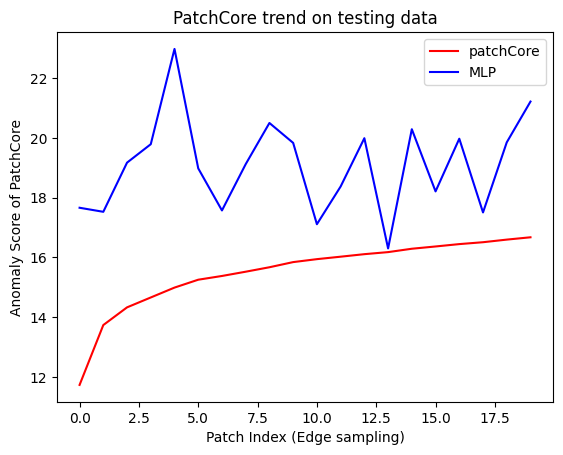

In [63]:
# out of curiousity, let's also see how the MLP model follows PatchCore on the boundaries and the middle sections

y1_boundaries = y1[:500:25] + y1[27652::125]  # 20 samples out of the first 500 points
y2_boundaries = y2[:500:25] + y2[27652::125]  # 20 samples out of the last 2500 points

draw_two_plots(y1_boundaries, y2_boundaries, x_axis="Patch Index (Edge sampling)", y_axis="Anomaly Score of PatchCore", title="PatchCore trend on testing data")

# Conclusion

The code above represents one experiment, but before arriving at the last result above, I went through many other experiments 
that I will detail the results for here.

But first, let's talk about the final result.

## Final results
The final result behaves more closely to patchCore, but there's still a relatively high error between the two results.

On the image classification level, we see there was 3 mistakes in 35 images (around 8%)

## Learnings
1. Improving the model architecture, by increasing the number of neurons in each layer didn't have any positive effect on the model.
2. Adding anomalous data really had a positive effect on correct estimation of anomaly score.
3. Learning happens better within the single image. In one experiment, instead of choosing some images for test, and some images for training, we merged all image patches, and then splitted them for training and test. In the latter case, we saw a higher chance of correctly classifying the images.



In [65]:
test_images_used_for_test

[PosixPath('datasets/MVTec_b/grid/test/good/006.png'),
 PosixPath('datasets/MVTec_b/grid/test/thread/002.png'),
 PosixPath('datasets/MVTec_b/grid/test/bent/004.png'),
 PosixPath('datasets/MVTec_b/grid/test/good/012.png'),
 PosixPath('datasets/MVTec_b/grid/test/broken/000.png'),
 PosixPath('datasets/MVTec_b/grid/test/metal_contamination/000.png'),
 PosixPath('datasets/MVTec_b/grid/test/thread/007.png'),
 PosixPath('datasets/MVTec_b/grid/test/metal_contamination/003.png'),
 PosixPath('datasets/MVTec_b/grid/test/metal_contamination/005.png'),
 PosixPath('datasets/MVTec_b/grid/test/glue/010.png'),
 PosixPath('datasets/MVTec_b/grid/test/broken/007.png'),
 PosixPath('datasets/MVTec_b/grid/test/thread/000.png'),
 PosixPath('datasets/MVTec_b/grid/test/good/004.png'),
 PosixPath('datasets/MVTec_b/grid/test/glue/004.png'),
 PosixPath('datasets/MVTec_b/grid/test/good/003.png'),
 PosixPath('datasets/MVTec_b/grid/test/good/013.png'),
 PosixPath('datasets/MVTec_b/grid/test/good/014.png'),
 PosixPath

In [70]:
type(test_data[0][0])

float